### Notebook to prototype REDCap API calls

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import pickle
import seaborn as sns

In [2]:
def api_call(url, query, logger=None):
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    print(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        print(f"RedCap API request Failed with HTTP Status: {http_status}")

    return query_df

In [52]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "Jan_2024"
current_nipoppy_manifest_csv = f"{release_dir}{current_release}/tabular/manifest.csv"
legacy_qpn_imaging_codes_xlsx = f"{release_dir}{current_release}/tabular/assessments/QPN_Imaging_Codes.xlsx"

# Legacy DoB
legacy_participants_DOB = f"{DATASET_ROOT}/tabular/legacy_freeze/QPN-DOB-90subjects.csv"
legacy_participants_DOB_codes = f"{DATASET_ROOT}/tabular/legacy_freeze/QPN-DOB-codes.csv"

# redcap_report_csv = f"{release_dir}{current_release}/tabular/assessments/COPN-MRIDataReport2023110_DATA_LABELS_2024-01-10_1004.csv"
redcap_report_csv = f"{release_dir}{current_release}/tabular/assessments/COPN-MRIDataReport2023110_DATA_LABELS_2024-02-19_0851.csv"

MRI_dates_csv = f"{DATASET_ROOT}/scratch/mri_dates_sanity_check.csv"
MRI_acq_data_csv = f"{release_dir}{current_release}/tabular/MRI_acqdata.csv"

# Sharp lab Neurocog dates
neurocog_date_xlsx = f"{release_dir}{current_release}/tabular/assessments/Sharp_QPN_List.xlsx"
revised_neurocog_date_xlsx = f"{release_dir}{current_release}/tabular/assessments/Sharp_QPN_List_revised.xlsx"

query_dict_pkl = f"{release_dir}{current_release}/tabular/redcap_query_dict.pkl"

### Manifest

In [53]:
visit_list = ["MRI_v1"] 
session_id_list = ["01"]
session_list = [f"ses-{idx}" for idx in session_id_list]

manifest_cols = ["participant_id", "visit", "session"]

current_nipoppy_manifest_df = pd.read_csv(current_nipoppy_manifest_csv)
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["visit"].isin(visit_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["session"].isin(session_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[manifest_cols]
current_nipoppy_manifest_df["participant_id"] = current_nipoppy_manifest_df["participant_id"].str.upper()
nipoppy_participants = current_nipoppy_manifest_df["participant_id"].unique()
n_participants = len(nipoppy_participants)
print(f"n_participants: {n_participants}")
current_nipoppy_manifest_df.head()

n_participants: 303


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


In [54]:
awol_participants = ['PD00296', 'PD01182', 'PD01258', 'MNI0136', 'MNI0147']

current_nipoppy_manifest_df[current_nipoppy_manifest_df["participant_id"].isin(awol_participants)]

,participant_id,visit,session
11,PD00296,MRI_v1,ses-01
72,PD01182,MRI_v1,ses-01
87,PD01258,MRI_v1,ses-01
200,MNI0136,MRI_v1,ses-01
203,MNI0147,MRI_v1,ses-01


### Legacy demographics and visit dates
- Using this while REDCap is getting updated

In [55]:
sheet_name = "recruit_manifest"
usecols = ["participant_id", "group", "sex", "dob", "visit_01"]
legacy_recruit_df = pd.read_excel(legacy_qpn_imaging_codes_xlsx, sheet_name=sheet_name, engine='openpyxl', usecols=usecols)
legacy_recruit_df["participant_id"] = legacy_recruit_df["participant_id"].str.upper()

legacy_col_dict = {"group": "legacy_group", "sex":"legacy_sex", "dob":"legacy_dob", "visit_01": "legacy_date_MRI"}
legacy_recruit_df = legacy_recruit_df.rename(columns=legacy_col_dict)

legacy_participants = legacy_recruit_df["participant_id"].unique()
n_legacy_participants = len(legacy_participants)
print(f"n_legacy_participants: {n_legacy_participants}")

legacy_recruit_df["legacy_dob"] = pd.to_datetime(legacy_recruit_df["legacy_dob"], errors="coerce", dayfirst=True)
legacy_recruit_df["legacy_date_MRI"] = pd.to_datetime(legacy_recruit_df["legacy_date_MRI"], errors="coerce", dayfirst=True)

# calculate age at MRI_V01
legacy_recruit_df["legacy_age_MRI"] = legacy_recruit_df["legacy_date_MRI"] - legacy_recruit_df["legacy_dob"]
legacy_recruit_df["legacy_age_MRI"] = np.round(legacy_recruit_df["legacy_age_MRI"].dt.days / 365.25, 2)

legacy_recruit_df["visit_id"] = "MRI_v1"
legacy_recruit_df.head()

n_legacy_participants: 208


,participant_id,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI,visit_id
0,MNI0056,M,1942-05-21,PD,2021-08-18,79.24,MRI_v1
1,MNI0058,M,1964-03-14,PD,2021-08-18,57.43,MRI_v1
2,MNI0068,M,1952-08-05,PD,2021-08-27,69.06,MRI_v1
3,MNI0079,F,1971-11-25,PD,2021-12-22,50.08,MRI_v1
4,MNI0103,M,1939-08-17,PD,2021-08-11,81.98,MRI_v1


#### Add legacy DoB

In [56]:
DOB_col = "Date of Birth/Date de naissance"
cross_ref_col = "Reference number"
record_col = "Record ID"

legacy_DOB = pd.read_csv(legacy_participants_DOB)
legacy_DOB = legacy_DOB.rename(columns={ DOB_col:"dob"})

legacy_DOB_codes = pd.read_csv(legacy_participants_DOB_codes)
legacy_DOB_codes = legacy_DOB_codes.rename(columns={record_col:"participant_id"})

legacy_DOB = pd.merge(legacy_DOB_codes, legacy_DOB, how="left", on=cross_ref_col).drop(columns=[cross_ref_col])

legacy_DOB["dob"] = pd.to_datetime(legacy_DOB["dob"], errors="coerce", dayfirst=False)
legacy_DOB.head()

,participant_id,dob
0,MNI0369,1951-01-01
1,MNI0381,1943-11-10
2,MNI0416,1952-01-11
3,MNI0420,1961-09-10
4,MNI0438,1951-04-25


#### Add MRI dates from Suivi_RPQ and dicom headers to the legacy df

In [57]:
MRI_dates_df = pd.read_csv(MRI_dates_csv)
n_mri_dates_participants = len(MRI_dates_df["participant_id"].unique())
print(f"n_mri_dates_participants: {n_mri_dates_participants}")

MRI_dates_df = MRI_dates_df[MRI_dates_df["visit_id"]=="MRI_v1"][["participant_id","visit_id","suivi_MRI_date","dicom_date"]]
MRI_dates_df["suivi_MRI_date"] = pd.to_datetime(MRI_dates_df["suivi_MRI_date"], errors="coerce", dayfirst=False)
MRI_dates_df["dicom_date"] = pd.to_datetime(MRI_dates_df["dicom_date"], errors="coerce", dayfirst=False)

legacy_recruit_df = pd.merge(MRI_dates_df, legacy_recruit_df, on=["participant_id","visit_id"], how="left")

legacy_recruit_df.head()

n_mri_dates_participants: 298


,participant_id,visit_id,suivi_MRI_date,dicom_date,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI
0,MNI0028,MRI_v1,NaT,2023-10-04,NaN,NaT,NaN,NaT,NaN
1,MNI0056,MRI_v1,2021-08-18,2021-08-18,M,1942-05-21,PD,2021-08-18,79.24
2,MNI0058,MRI_v1,2021-08-18,2021-08-18,M,1964-03-14,PD,2021-08-18,57.43
3,MNI0068,MRI_v1,2021-08-27,2021-08-27,M,1952-08-05,PD,2021-08-27,69.06
4,MNI0079,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08


#### Add MRI acq dates

In [58]:
MRI_acq_data_df = pd.read_csv(MRI_acq_data_csv).drop(columns=["index","participant_dicom_dir"])
MRI_acq_data_df.loc[MRI_acq_data_df["session"]=="ses-01", "visit_id"] = "MRI_v1"
MRI_acq_data_df.loc[MRI_acq_data_df["session"]=="ses-02", "visit_id"] = "MRI_v2"

legacy_recruit_df = pd.merge(MRI_acq_data_df, legacy_recruit_df, on=["participant_id","visit_id"], how="left")
legacy_recruit_df["scanner_acq_date"] = pd.to_datetime(legacy_recruit_df["scanner_acq_date"], errors="coerce", dayfirst=False)
legacy_recruit_df.head()

,participant_id,session,scanner_acq_date,visit_id,suivi_MRI_date,dicom_date,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI
0,MNI0028,ses-01,2023-10-04,MRI_v1,NaT,2023-10-04,NaN,NaT,NaN,NaT,NaN
1,MNI0056,ses-01,2021-08-18,MRI_v1,2021-08-18,2021-08-18,M,1942-05-21,PD,2021-08-18,79.24
2,MNI0058,ses-01,2021-08-18,MRI_v1,2021-08-18,2021-08-18,M,1964-03-14,PD,2021-08-18,57.43
3,MNI0068,ses-01,2021-08-27,MRI_v1,2021-08-27,2021-08-27,M,1952-08-05,PD,2021-08-27,69.06
4,MNI0079,ses-01,2021-12-22,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08


In [59]:
MRI_acq_data_df.head()

,participant_id,session,scanner_acq_date,visit_id
0,MNI0028,ses-01,2023-10-04,MRI_v1
1,MNI0056,ses-01,2021-08-18,MRI_v1
2,MNI0058,ses-01,2021-08-18,MRI_v1
3,MNI0068,ses-01,2021-08-27,MRI_v1
4,MNI0079,ses-01,2021-12-22,MRI_v1


### Redcap config
QPN specific reports:
['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']

In [60]:
redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
redcap_config = json.load(open(redcap_config_json))
url = redcap_config["url"]
redcap_reports = list(redcap_config["queries"].keys())
n_redcap_reports = len(redcap_reports)
print(f"redcap_reports ({n_redcap_reports}): {redcap_reports}")

redcap_reports (12): ['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA', 'C-OPN/QPN - OMEGA - Neuropsy', 'QPN MoCA-UPDRS-Neuropsy data_Sarah']


In [61]:
load_local_redcap = True

query_dict = {}
redcap_participants = []

if load_local_redcap:
    print(f"Loading redcap data from {query_dict_pkl}...")
    with open(query_dict_pkl, 'rb') as fp:
        query_dict = pickle.load(fp)

    for query_label in query_dict.keys():
        query_df = query_dict[query_label]
        _participants = query_df["record_id"].unique()
        redcap_participants.extend(_participants)
        n_participants = len(redcap_participants)
        print(f"Loaded {n_participants} participants from {query_label}...")


else:
    print(f"Fetching redcap data from {url}...")

    api_report_list = ["Demographic QPN","Victoria - Weston Project","QPN MoCA-UPDRS-Neuropsy data_Sarah"]
    for query_label in redcap_reports:

        if query_label in api_report_list:
            query = redcap_config["queries"][query_label]

            # run query
            print(f"Running query {query_label}...")
            time.sleep(1)
            query_df = api_call(url, query, logger=None)
            query_df["record_id"] = query_df["record_id"].str.upper()

            # get the list of participants
            _participants = query_df["record_id"].unique()
            redcap_participants.extend(_participants)
            n_participants = len(redcap_participants)

            # get the list of redcap events
            redcap_events = query_df["redcap_event_name"].unique()
            n_events = len(redcap_events)

            print(f"Fetched {n_participants} participants and {n_events} event_ids: {redcap_events}")

            query_dict[query_label] = query_df.copy()
        
        with open(query_dict_pkl, 'wb') as fp:
            pickle.dump(query_dict, fp)

redcap_participants = list(set(redcap_participants))

Loading redcap data from /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/tabular/redcap_query_dict.pkl...
Loaded 1387 participants from Demographic QPN...
Loaded 2237 participants from Victoria - Weston Project...
Loaded 3624 participants from QPN MoCA-UPDRS-Neuropsy data_Sarah...


### Redcap report
This comes from Sarah with DoB

In [62]:
redcap_report_df = pd.read_csv(redcap_report_csv)

demo_col_dict = {"Record ID:": "participant_id", "Event Name": "redcap_event_name", 
                 "Enrolment Group:": "group", "Date of Birth":"dob", "1. Sex": "sex", 
                 "Date of MoCA administration": "moca_date","MDS-UPDRS Date":"updrs_date",
                 "Neuropsycholgical Test Date:": "neuropsy_date"}

redcap_report_df = redcap_report_df[list(demo_col_dict.keys())].rename(columns=demo_col_dict)

redcap_report_df["participant_id"] = redcap_report_df["participant_id"].str.upper()
redcap_report_df["sex"] = redcap_report_df["sex"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

redcap_report_participants = redcap_report_df["participant_id"].unique()
n_participants = redcap_report_df["participant_id"].nunique()
n_events = redcap_report_df["redcap_event_name"].unique()
n_DOBs = redcap_report_df[redcap_report_df['dob'].notnull()]["participant_id"].nunique()

print(f"Number of participants: {n_participants}")
print(f"Number of events: {n_events}")

print(f"Number of available DOB: {n_DOBs}")
redcap_report_df.head()

Number of participants: 1326
Number of events: ['Baseline (Arm 1: C-OPN)' '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']
Number of available DOB: 592


,participant_id,redcap_event_name,group,dob,sex,moca_date,updrs_date,neuropsy_date
0,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,2/9/1951,M,11/9/2021,11/9/2021,NaN
1,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,12/12/2023,12/12/2023,12/12/2023
2,CHQ0035,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,8/28/1951,F,3/1/2023,3/1/2023,NaN
3,CHQ0036,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,NaN,NaN,NaN,NaN,NaN
4,CHQ0037,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,8/14/1968,M,1/24/2024,1/24/2024,1/24/2024


### Add dob from legacy data

In [63]:
legacy_dob_participants = legacy_DOB["participant_id"].unique()
legacy_dob_participants = set(legacy_dob_participants) & set(redcap_report_df[redcap_report_df["dob"].isna()]["participant_id"])

print(f"Number of legacy participants with DOB: {len(legacy_dob_participants)}")
      
redcap_report_df["dob"] = pd.to_datetime(redcap_report_df["dob"], errors="coerce", dayfirst=False)

for p in legacy_dob_participants:
    redcap_report_df.loc[(redcap_report_df["participant_id"] == p) & 
                         (redcap_report_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"), 
                         "dob"] = legacy_DOB.loc[legacy_DOB["participant_id"]==p,"dob"].values[0]
    
n_DOBs = redcap_report_df[redcap_report_df['dob'].notnull()]["participant_id"].nunique()
print(f"Number of available DOB: {n_DOBs}")

Number of legacy participants with DOB: 67
Number of available DOB: 658


#### Calculate ages from dates in the redcap report

In [64]:
redcap_report_df["moca_date"] = pd.to_datetime(redcap_report_df["moca_date"], errors="coerce", dayfirst=False)
redcap_report_df["updrs_date"] = pd.to_datetime(redcap_report_df["updrs_date"], errors="coerce", dayfirst=False)
redcap_report_df["neuropsy_date"] = pd.to_datetime(redcap_report_df["neuropsy_date"], errors="coerce", dayfirst=False)

## fill in dob for followup visits
dob_df = redcap_report_df[["participant_id","dob"]].copy()
# dob_df = dob_df.dropna(subset="dob")
redcap_report_df = pd.merge(redcap_report_df.drop(columns="dob"), dob_df, on="participant_id")

redcap_report_df["age_moca"] = redcap_report_df["moca_date"] - redcap_report_df["dob"]
redcap_report_df["age_moca"] = np.round(redcap_report_df["age_moca"].dt.days / 365.25, 2)

redcap_report_df["age_updrs"] = redcap_report_df["updrs_date"] - redcap_report_df["dob"]
redcap_report_df["age_updrs"] = np.round(redcap_report_df["age_updrs"].dt.days / 365.25, 2)

redcap_report_df["age_neuropsy"] = redcap_report_df["neuropsy_date"] - redcap_report_df["dob"]
redcap_report_df["age_neuropsy"] = np.round(redcap_report_df["age_neuropsy"].dt.days / 365.25, 2)

redcap_report_participants = redcap_report_df["participant_id"].unique()
print(f"n_redcap_report_df: {len(redcap_report_participants)}")

redcap_report_df.head()

n_redcap_report_df: 1326


,participant_id,redcap_event_name,group,sex,moca_date,updrs_date,neuropsy_date,dob,age_moca,age_updrs,age_neuropsy
0,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,2021-11-09,2021-11-09,NaT,1951-02-09,70.75,70.75,NaN
1,CHQ0011,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,2021-11-09,2021-11-09,NaT,NaT,NaN,NaN,NaN
2,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,2023-12-12,2023-12-12,2023-12-12,1951-02-09,72.84,72.84,72.84
3,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,2023-12-12,2023-12-12,2023-12-12,NaT,NaN,NaN,NaN
4,CHQ0035,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,2023-03-01,2023-03-01,NaT,1951-08-28,71.51,71.51,NaN


### Participant tallys

In [65]:
# redcap_participants = [p.upper() for p in redcap_participants]

print(f"Number of nipoppy participants: {len(nipoppy_participants)}")
print(f"Number of legacy participants: {len(legacy_participants)}")
print(f"Number of redcap participants: {len(redcap_participants)}")
print(f"Number of redcap report participants: {len(redcap_report_participants)}")


a = set(nipoppy_participants)
b = set(legacy_participants)
c = set(redcap_participants)
d = set(redcap_report_participants)

nipoppy_legacy_common_participants = a.intersection(b)
n_nipoppy_legacy_common_participants = len(nipoppy_legacy_common_participants)

nipoppy_redcap_common_participants = a.intersection(c)
n_nipoppy_redcap_common_participants = len(nipoppy_redcap_common_participants)

nipoppy_redcap_report_common_participants = a.intersection(d)
n_nipoppy_redcap_report_common_participants = len(nipoppy_redcap_report_common_participants)

nipoppy_not_in_legacy_participants  = a.difference(b) # nipoppy participants not in the legacy spreadsheets
n_nipoppy_not_in_legacy_participants = len(nipoppy_not_in_legacy_participants)

nipoppy_not_in_redcap_participants  = a.difference(c) # nipoppy participants not in the redcap yet
n_nipoppy_not_in_redcap_participants = len(nipoppy_not_in_redcap_participants)

nipoppy_not_in_redcap_report_participants  = a.difference(d) # nipoppy participants not in the redcap report yet
n_nipoppy_not_in_redcap_report_participants = len(nipoppy_not_in_redcap_report_participants)

missing_nipoppy_participants = a.difference(c).difference(d)
n_missing_nipoppy_participants = len(missing_nipoppy_participants)

new_redcap_participants  = nipoppy_redcap_common_participants.difference(d) # nipoppy-redcap participants not in the report yet
n_new_redcap_participants = len(new_redcap_participants)

print(f"nipoppy-legacy common participants: {n_nipoppy_legacy_common_participants}")
print(f"nipoppy-redcap common participants: {n_nipoppy_redcap_common_participants}")
print(f"nipoppy-recdap_report common participants: {n_nipoppy_redcap_report_common_participants}")

print(f"nipoppy-redcap participants not in the report yet (n={n_new_redcap_participants}): {new_redcap_participants}")
print(f"missing_nipoppy_participants (n={n_missing_nipoppy_participants}): {missing_nipoppy_participants}")

Number of nipoppy participants: 303
Number of legacy participants: 208
Number of redcap participants: 1387
Number of redcap report participants: 1326
nipoppy-legacy common participants: 206
nipoppy-redcap common participants: 292
nipoppy-recdap_report common participants: 292
nipoppy-redcap participants not in the report yet (n=0): set()
missing_nipoppy_participants (n=11): {'PD00296', 'MNI0147', 'PD01182', 'PD01258', 'MNI0482', 'PD01686', 'PD01687', 'PD01662', 'PD01253', 'MNI0436', 'MNI0136'}


### Demographics, Dx, and summary clinical scores
- `Demographic QPN`
    - "study_visit_age", "gender", "yrs_education"
        - Note: study visit age will be different for different assessments
        - **study_visit_age is not useful since it's self reported at random times**
- `Diagnosis QPN` does not have Dx for all participants
- `Victoria - Weston Project` (Legend for Determined diagnosis)
    - If score = 0, Parkinson's Disease (PD)  
    - If score = 1, Progressive Supranuclear Palsy (PSP)  
    - If score = 2, Multiple System Atrophy (MSA) 
    - If score = 3, Corticobasal Syndrome (CBS)  
    - If score = 4, Dementia wi1th Lewy Bodies (DLB)  
    - If score = 5, Frontotemporal Dementia (FTD)  
    - If score = 6, Essential Tremor (ET)  
    - If score = 7, REM Sleep Behaviour Disorder (RBD)
- `MotorAndNon-Motor` 
    - summary clinical scores (updrs, moca)
    - verify moca column with extra point i.e. `moca_extra_point`
- `QPN MoCA-UPDRS-Neuropsy data_Sarah`
    - Has additional updrs variables 
    





### Aggregate useful redcap data

In [66]:
index_columns = ["record_id", "redcap_event_name"]

demo_cols = ["gender", "yrs_education"]
demo_df = query_dict['Demographic QPN'][index_columns + demo_cols].copy()

dx_cols = ["diagnosis_determined", "duration_disease"]
dx_df = query_dict['Victoria - Weston Project'][index_columns + dx_cols]

diagnosis_determined_label_map = {
    "0" : "PD",
    "1" : "PSP",
    "2" : "MSA",
    "3" : "CBS", 
    "4" : "DLB",
    "5" : "FTD", 
    "6" : "ET",
    "7" : "RBD"
}
dx_df.loc[:,"diagnosis_determined"] = dx_df["diagnosis_determined"].astype(str).replace(diagnosis_determined_label_map).copy()

updrs_cols = ["mds_updrs_h_y", "updrs_score_part_1", "updrs_score_part_2", "updrs_score_part_3", "updrs_score_part_4"]
moca_cols = ['moca_result'] 
moca_subscore_cols = ['moca_result_2', 'moca_result_3', 'moca_result_4','moca_result_5', 'moca_result_6', 
                      'moca_result_7', 'moca_result_8','moca_result_9']

score_cols = updrs_cols + moca_cols
score_df = query_dict["QPN MoCA-UPDRS-Neuropsy data_Sarah"][index_columns + score_cols].copy()

redcap_df = pd.merge(demo_df, dx_df, on=index_columns)
redcap_df = pd.merge(score_df, redcap_df, on=index_columns, how="left")

redcap_df["gender"] = redcap_df["gender"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

n_redcap_common_participants = len(redcap_df["record_id"].unique())
print(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")

print(f"redcap events: {redcap_df['redcap_event_name'].unique()}")

redcap_df.head()

Found 1387 recdap-nipoppy common participants
redcap events: ['Baseline (Arm 1: C-OPN)' '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '60 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '54 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,record_id,redcap_event_name,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,gender,yrs_education,diagnosis_determined,duration_disease
0,CHQ0009,Baseline (Arm 1: C-OPN),,,,,,,NaN,NaN,NaN,NaN
1,CHQ0011,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,11,8,36,0,24,NaN,NaN,NaN,NaN
2,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,7,12,41,0,30,NaN,NaN,NaN,NaN
3,CHQ0012,Baseline (Arm 1: C-OPN),,,,,,,NaN,NaN,NaN,NaN
4,CHQ0035,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,6,11,46,7,22,NaN,NaN,NaN,NaN


### Merge MRI, legacy and redcap tabular data

In [67]:
# merge redcap query df
redcap_event_list = ['Baseline (Arm 1: C-OPN)',
                     '12 Months Follow-Up/Suivi (Arm 1: C-OPN)', 
                     '18 Months Follow-Up/Suivi (Arm 1: C-OPN)',
                     '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']

nipoppy_redcap_df = redcap_df[(redcap_df["record_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_df["redcap_event_name"].isin(redcap_event_list))].copy()

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["record_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")
               
nipoppy_redcap_df = nipoppy_redcap_df.replace("", np.nan)
nipoppy_redcap_df = nipoppy_redcap_df.rename(columns={"record_id": "participant_id"})

nipoppy_redcap_df = pd.merge(nipoppy_redcap_df, legacy_recruit_df, on="participant_id", how="left")

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["participant_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

redcap_events = nipoppy_redcap_df["redcap_event_name"].unique()
print(f"redcap_events: {redcap_events}")

nipoppy_redcap_df.head()

n_nipoppy_redcap_participants: 292
n_nipoppy_redcap_participants: 292
redcap_events: ['Baseline (Arm 1: C-OPN)' '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']


,participant_id,redcap_event_name,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,gender,yrs_education,...,session,scanner_acq_date,visit_id,suivi_MRI_date,dicom_date,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI
0,MNI0028,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,0,2,29,0,28,M,18,...,ses-01,2023-10-04,MRI_v1,NaT,2023-10-04,NaN,NaT,NaN,NaT,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,22,M,6,...,ses-01,2021-08-18,MRI_v1,2021-08-18,2021-08-18,M,1942-05-21,PD,2021-08-18,79.24
2,MNI0058,Baseline (Arm 1: C-OPN),"(1) Unilateral involvement only, usually with ...",0,6,26,0,25,M,11,...,ses-01,2021-08-18,MRI_v1,2021-08-18,2021-08-18,M,1964-03-14,PD,2021-08-18,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,11,8,28,0,NaN,M,12,...,ses-01,2021-08-27,MRI_v1,2021-08-27,2021-08-27,M,1952-08-05,PD,2021-08-27,69.06
4,MNI0079,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,13,10,22,8,26,F,20+,...,ses-01,2021-12-22,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08


### Merge redcap_report_df with nipoppy_redcap df

In [68]:
nipoppy_redcap_report_df = redcap_report_df[(redcap_report_df["participant_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_report_df["redcap_event_name"].isin(redcap_event_list))].copy()

n_nipoppy_redcap_report_participants = len(nipoppy_redcap_report_df["participant_id"].unique())
print(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_report_participants}")
               
nipoppy_redcap_report_df = nipoppy_redcap_report_df.replace("", np.nan)

## Get all the age columns
nipoppy_redcap_report_df_filtered = nipoppy_redcap_report_df[["participant_id", "redcap_event_name", "group", "sex", "dob",
                                                               "moca_date",	"updrs_date", "neuropsy_date", 
                                                               "age_moca", "age_updrs", "age_neuropsy"]].copy()

nipoppy_redcap_filtered_df = pd.merge(nipoppy_redcap_report_df_filtered, nipoppy_redcap_df, 
                                      on=["participant_id","redcap_event_name"], how="left")

n_participants = nipoppy_redcap_filtered_df["participant_id"].nunique()
print(f"n_nipoppy_redcap_report_merged_participants: {n_participants}")

# calculate suivi IRM and dicom ages based on redcap DoB
nipoppy_redcap_filtered_df["suivi_age_MRI"] = nipoppy_redcap_filtered_df["suivi_MRI_date"] - nipoppy_redcap_filtered_df["dob"]
nipoppy_redcap_filtered_df["suivi_age_MRI"] = np.round(nipoppy_redcap_filtered_df["suivi_age_MRI"].dt.days / 365.25, 2)

nipoppy_redcap_filtered_df["dicom_age_MRI"] = nipoppy_redcap_filtered_df["scanner_acq_date"] - nipoppy_redcap_filtered_df["dob"]
nipoppy_redcap_filtered_df["dicom_age_MRI"] = np.round(nipoppy_redcap_filtered_df["dicom_age_MRI"].dt.days / 365.25, 2)

print(f"nipoppy_redcap_filtered_df shape: {nipoppy_redcap_filtered_df.shape}")
nipoppy_redcap_filtered_df.head(10)

n_nipoppy_redcap_participants: 292
n_nipoppy_redcap_report_merged_participants: 292
nipoppy_redcap_filtered_df shape: (1056, 33)


,participant_id,redcap_event_name,group,sex,dob,moca_date,updrs_date,neuropsy_date,age_moca,age_updrs,...,visit_id,suivi_MRI_date,dicom_date,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI,suivi_age_MRI,dicom_age_MRI
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1963-07-27,2023-10-04,2023-10-04,2023-10-03,60.19,60.19,...,MRI_v1,NaT,2023-10-04,NaN,NaT,NaN,NaT,NaN,NaN,60.19
1,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1942-05-21,2021-06-11,2021-06-11,NaT,79.06,79.06,...,MRI_v1,2021-08-18,2021-08-18,M,1942-05-21,PD,2021-08-18,79.24,79.24,79.24
2,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1964-03-14,2021-07-23,2021-07-23,NaT,57.36,57.36,...,MRI_v1,2021-08-18,2021-08-18,M,1964-03-14,PD,2021-08-18,57.43,57.43,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1952-05-08,NaT,2021-08-27,NaT,NaN,69.30,...,MRI_v1,2021-08-27,2021-08-27,M,1952-08-05,PD,2021-08-27,69.06,69.30,69.30
4,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,1971-11-25,2021-12-22,2022-01-21,NaT,50.08,50.16,...,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08,50.08,50.08
5,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaT,2021-12-22,2022-01-21,NaT,NaN,NaN,...,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08,NaN,NaN
6,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,1971-11-25,NaT,NaT,NaT,NaN,NaN,...,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08,50.08,50.08
7,MNI0079,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,...,MRI_v1,2021-12-22,2021-12-22,F,1971-11-25,PD,2021-12-22,50.08,NaN,NaN
8,MNI0103,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1939-08-17,2021-11-08,2021-10-01,NaT,82.23,82.12,...,MRI_v1,2021-08-11,2021-11-16,M,1939-08-17,PD,2021-08-11,81.98,81.98,82.23
9,MNI0109,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,1976-06-02,2021-09-24,2021-09-24,NaT,45.31,45.31,...,MRI_v1,2021-09-24,2021-09-24,F,1976-02-06,PD,2021-09-24,45.63,45.31,45.31


### Add Sharp Lab's Neurocog dates

In [69]:
neurocog_data = pd.read_excel(neurocog_date_xlsx, sheet_name="Sheet1", engine='openpyxl')
neurocog_data = neurocog_data.rename(columns={"date_of_assessment":"neurocog_date"})
neurocog_data = neurocog_data.drop(columns=["assessment"])
neurocog_participants = neurocog_data["participant_id"].unique()
n_neurocog_participants = len(neurocog_participants)
print(f"n_neurocog_participants: {n_neurocog_participants} (total rows: {len(neurocog_data)})")
neurocog_screen_participants = set(neurocog_participants) & set(nipoppy_redcap_filtered_df['participant_id'].unique()) 
neurocog_not_screen_participants = set(neurocog_participants) - set(nipoppy_redcap_filtered_df['participant_id'].unique())
screen_not_neurocog_participants = set(nipoppy_redcap_filtered_df['participant_id'].unique()) - set(neurocog_participants)
print(f"neurocog_nipoppy_redcap_filtered_df_participants: {len(neurocog_screen_participants)}")
print(f"neurocog_not_nipoppy_redcap_filtered_df_participants: {len(neurocog_not_screen_participants)}")
print(f"nipoppy_redcap_filtered_df_not_neurocog_participants: {len(screen_not_neurocog_participants)}")

neurocog_data["REDCap_availability"] = 1
neurocog_data.loc[neurocog_data["participant_id"].isin(neurocog_not_screen_participants), "REDCap_availability"] = 0

neurocog_data.to_excel(revised_neurocog_date_xlsx, index=False)

neurocog_data = neurocog_data.sort_values(by=["participant_id","neurocog_date"])   
neurocog_data[neurocog_data.duplicated(subset=["participant_id"])]



n_neurocog_participants: 208 (total rows: 210)
neurocog_nipoppy_redcap_filtered_df_participants: 145
neurocog_not_nipoppy_redcap_filtered_df_participants: 63
nipoppy_redcap_filtered_df_not_neurocog_participants: 147


,participant_id,neurocog_date,redcap_event_name,REDCap_availability
8,MNI0110,2022-08-02,12 Months Follow-Up/Suivi (Arm 1: C-OPN),1
14,MNI0144,2023-06-21,18 Months Follow-Up/Suivi (Arm 1: C-OPN),1


In [70]:
nipoppy_redcap_filtered_df = pd.merge(nipoppy_redcap_filtered_df, neurocog_data, on=["participant_id","redcap_event_name"], how="left")

nipoppy_redcap_filtered_df["age_neurocog"] = nipoppy_redcap_filtered_df["neurocog_date"] - nipoppy_redcap_filtered_df["dob"]
nipoppy_redcap_filtered_df["age_neurocog"] = np.round(nipoppy_redcap_filtered_df["age_neurocog"].dt.days / 365.25, 2)

print(f"nipoppy_redcap_filtered_df shape: {nipoppy_redcap_filtered_df.shape}")
nipoppy_redcap_filtered_df.head()

nipoppy_redcap_filtered_df shape: (1056, 36)


,participant_id,redcap_event_name,group,sex,dob,moca_date,updrs_date,neuropsy_date,age_moca,age_updrs,...,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI,suivi_age_MRI,dicom_age_MRI,neurocog_date,REDCap_availability,age_neurocog
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1963-07-27,2023-10-04,2023-10-04,2023-10-03,60.19,60.19,...,NaN,NaT,NaN,NaT,NaN,NaN,60.19,2023-10-04,1.0,60.19
1,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1942-05-21,2021-06-11,2021-06-11,NaT,79.06,79.06,...,M,1942-05-21,PD,2021-08-18,79.24,79.24,79.24,2021-08-11,1.0,79.23
2,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1964-03-14,2021-07-23,2021-07-23,NaT,57.36,57.36,...,M,1964-03-14,PD,2021-08-18,57.43,57.43,57.43,2021-08-18,1.0,57.43
3,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,1952-05-08,NaT,2021-08-27,NaT,NaN,69.30,...,M,1952-08-05,PD,2021-08-27,69.06,69.30,69.30,2021-08-18,1.0,69.28
4,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,1971-11-25,2021-12-22,2022-01-21,NaT,50.08,50.16,...,F,1971-11-25,PD,2021-12-22,50.08,50.08,50.08,2022-01-21,1.0,50.16


### Generate bagel(s)
- neuro-bagel
- dash-bagel (currenly this is a melted version of neuro-bagel)

**Note**: QPN has different `visit` names for MRI, UPDRS, MoCA, Neuropsy etc.

Using redcap events as evidence of multiple visits. However we are NOT assuming that two assessments (e.g. UPDRS and MoCA) are co-acquired in the same redcap event. This will be inferred using dates once available. 

In [71]:
redcap_index_cols = ["participant_id", "redcap_event_name"]
redcap_event_visit_id_dict = {"Baseline (Arm 1: C-OPN)": "v1"}

demo_cols = ['group', 'sex', 'yrs_education']
dx_cols = ['diagnosis_determined', 'duration_disease']
date_columns = ["moca_date", "updrs_date", "neuropsy_date", "neurocog_date", "suivi_MRI_date", "scanner_acq_date", "legacy_date_MRI"]
age_cols = ["legacy_age_MRI","suivi_age_MRI","dicom_age_MRI","age_moca", "age_updrs", "age_neuropsy", "age_neurocog"]

screen_cols = redcap_index_cols + demo_cols + dx_cols + date_columns + age_cols

screen_cols_rename_dict = {
    "yrs_education": "years_education_at_screening",
    # "diagnosis_determined": "diagnosis",
    "duration_disease": "duration_disease_at_screening",
    "group": "group_at_screening"
}

screen_df = nipoppy_redcap_filtered_df[screen_cols].copy()
screen_df = screen_df.rename(columns=screen_cols_rename_dict)

# ------------------------------------------------------------------------------------ #
# Check and add nipoppy participants which yet don't have any redcap data
# Only populates the participant_id and bids_id columns (required by neurobagel)
# ------------------------------------------------------------------------------------ #
nipoppy_participants_without_pheno_data_df = pd.DataFrame()
nipoppy_participants_without_pheno_data_df["participant_id"] = list(missing_nipoppy_participants)
nipoppy_participants_without_pheno_data_df["redcap_event_name"] = "missing"
nipoppy_participants_without_pheno_data_df["assessment"] = "MRI" # all QPN participants should have an MRI


print(f"appending {nipoppy_participants_without_pheno_data_df.shape[0]} participants without pheno data")
screen_df = pd.concat([screen_df, nipoppy_participants_without_pheno_data_df], axis=0)

print(f"screen_df participants: {screen_df['participant_id'].nunique()}")
# ------------------------------------------------------------------------------------ #
print(f"screen_df shape: {screen_df.shape}")
screen_df.head()

appending 11 participants without pheno data
screen_df participants: 303
screen_df shape: (1067, 22)


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,diagnosis_determined,duration_disease_at_screening,moca_date,updrs_date,neuropsy_date,...,scanner_acq_date,legacy_date_MRI,legacy_age_MRI,suivi_age_MRI,dicom_age_MRI,age_moca,age_updrs,age_neuropsy,age_neurocog,assessment
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,PD,3.5,2023-10-04,2023-10-04,2023-10-03,...,2023-10-04,NaT,NaN,NaN,60.19,60.19,60.19,60.19,60.19,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,6,NaN,6.5,2021-06-11,2021-06-11,NaT,...,2021-08-18,2021-08-18,79.24,79.24,79.24,79.06,79.06,NaN,79.23,NaN
2,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,11,PD,3.8,2021-07-23,2021-07-23,NaT,...,2021-08-18,2021-08-18,57.43,57.43,57.43,57.36,57.36,NaN,57.43,NaN
3,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,12,PD,10.2,NaT,2021-08-27,NaT,...,2021-08-27,2021-08-27,69.06,69.30,69.30,NaN,69.30,NaN,69.28,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,20+,PD,6.8,2021-12-22,2022-01-21,NaT,...,2021-12-22,2021-12-22,50.08,50.08,50.08,50.08,50.16,NaN,50.16,NaN


### Pivot the screen_df to conform to tabular demographics CSV schema
- picking dicom date as the MRI_v1 date. Need to validate these against Suivi dates

In [72]:
def assign_assessment_visits(participant_df, id_vars, age_col_dict):

    redcap_event_months_dict = {"Baseline (Arm 1: C-OPN)": 0, "12 Months Follow-Up/Suivi (Arm 1: C-OPN)": 12,
                            "18 Months Follow-Up/Suivi (Arm 1: C-OPN)": 18, "24 Months Follow-Up/Suivi (Arm 1: C-OPN)": 24}

    if "Baseline (Arm 1: C-OPN)" in participant_df["redcap_event_name"].unique():
        participant_df_melt = participant_df.melt(id_vars=id_vars, var_name="assessment", value_name="age")
        
        # removes assessment rows with missing age (artifact of the melt operation)
        participant_df_melt = participant_df_melt.dropna(subset=["age"], how="all", axis=0)

        if len(participant_df_melt) > 0:

            # assign months_since_baseline to be able to sort the dataframe based on time
            participant_df_melt.loc[:,"months_since_baseline"] = participant_df_melt["redcap_event_name"].replace(redcap_event_months_dict)
            participant_df_melt = participant_df_melt.sort_values(["participant_id","months_since_baseline"])
            
            # drops duplicate MRI visits (artifact of merge operation from MRI dicom dates)
            participant_df_melt = participant_df_melt.drop_duplicates(subset=["participant_id","assessment","age"], keep="first")
            
            participant_df_melt["assessment"] = participant_df_melt["assessment"].replace(age_col_dict)

            # 
            new_participant_df = pd.DataFrame() # avoids messy .loc assignment to the original unsorted df 
            for assessment in participant_df_melt["assessment"].unique():
                participant_assessment_df = participant_df_melt[participant_df_melt["assessment"] == assessment].sort_values("age")
                n_visits = len(participant_assessment_df)
                # print(f"n_visits for {assessment}: {n_visits}")
                participant_assessment_df["visit_id"] = np.array(range(1, n_visits+1))
                new_participant_df = pd.concat([new_participant_df, participant_assessment_df], axis=0)

            new_participant_df = new_participant_df.drop(columns=["months_since_baseline"])   
            new_participant_df["visit_id"] = "v" + new_participant_df["visit_id"].astype(str)            
 
        else:
            print(f"Participant {participant_df['participant_id'].unique()} has no assessment info")
            new_participant_df = participant_df[id_vars].copy()
    else:
        print(f"Participant {participant_df['participant_id'].unique()} has no baseline visit")
        new_participant_df = participant_df[id_vars].copy()

    return new_participant_df


In [73]:
id_vars=["participant_id","redcap_event_name","group_at_screening","sex",
         "years_education_at_screening","duration_disease_at_screening", "diagnosis_determined"]

temporal_cols = ["medication_status"] + updrs_cols + moca_cols

age_col_dict = {"dicom_age_MRI": "MRI",
                "age_updrs": "UPDRS", 
                "age_moca": "MOCA", 
                "age_neuropsy": "NEUROPSY",
                "age_neurocog": "NEUROCOG"}

demographic_df = pd.DataFrame()
for participant_id in screen_df["participant_id"].unique():
    participant_df = screen_df[screen_df["participant_id"] == participant_id].copy()
    participant_df = participant_df[id_vars + list(age_col_dict.keys())].copy()
    participant_df = assign_assessment_visits(participant_df, id_vars, age_col_dict)

    if participant_df is not None:
        demographic_df = pd.concat([demographic_df, participant_df], axis=0)    


demographic_df = demographic_df.sort_values(["participant_id", "visit_id"])
reorder_cols = id_vars + ["assessment", "visit_id", "age"]
demographic_df = demographic_df[reorder_cols]

demographic_df["visit"] = demographic_df["assessment"] + "_" + demographic_df["visit_id"]
demographic_df["assessment"] = demographic_df["assessment"].fillna("missing")
demographic_df["visit_id"] = demographic_df["visit_id"].fillna("v0")

demographic_df.head()

Participant ['MNI0602'] has no assessment info
Participant ['PD00296'] has no baseline visit
Participant ['MNI0147'] has no baseline visit
Participant ['PD01182'] has no baseline visit
Participant ['PD01258'] has no baseline visit
Participant ['MNI0482'] has no baseline visit
Participant ['PD01686'] has no baseline visit
Participant ['PD01687'] has no baseline visit
Participant ['PD01662'] has no baseline visit
Participant ['PD01253'] has no baseline visit
Participant ['MNI0436'] has no baseline visit
Participant ['MNI0136'] has no baseline visit


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
1,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,UPDRS,v1,60.19,UPDRS_v1
2,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MOCA,v1,60.19,MOCA_v1
3,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROPSY,v1,60.19,NEUROPSY_v1
4,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROCOG,v1,60.19,NEUROCOG_v1


In [74]:
demographic_df[demographic_df["participant_id"] == "PD01253"]

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
8,PD01253,missing,NaN,NaN,NaN,NaN,NaN,missing,v0,NaN,NaN


In [75]:
print(f"demographic_df participants: {demographic_df['participant_id'].nunique()}")
print(len(demographic_df))

# demographic_df = demographic_df.drop_duplicates(subset=["assessment", "age"])

print(f"demographic_df participants: {demographic_df['participant_id'].nunique()}")
print(len(demographic_df))

demographic_df participants: 303
1017
demographic_df participants: 303
1017


In [76]:
demographic_df.tail()

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
4,PD01759,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,NaN,NaN,NaN,MOCA,v1,66.18,MOCA_v1
8,PD01759,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,NaN,NaN,NaN,NEUROCOG,v1,66.18,NEUROCOG_v1
1,PD01759,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,NaN,NaN,NaN,MRI,v2,66.18,MRI_v2
0,UDM0045,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,17,3.6,PD,MRI,v1,66.78,MRI_v1
4,UDM0045,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,17,3.6,PD,UPDRS,v1,66.78,UPDRS_v1


In [77]:
demographic_df[demographic_df["participant_id"] == "MNI0342"]

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
1,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,UPDRS,v1,66.56,UPDRS_v1
2,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,MOCA,v1,66.56,MOCA_v1
3,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,NEUROPSY,v1,66.57,NEUROPSY_v1


### Add Phenotype data

In [78]:
updrs_df = nipoppy_redcap_filtered_df[redcap_index_cols + updrs_cols].copy()
updrs_df["assessment"] = "UPDRS"
updrs_df["medication_status"] = np.nan

moca_df = nipoppy_redcap_filtered_df[redcap_index_cols + moca_cols].copy()
moca_df["assessment"] = "MOCA"
moca_df["medication_status"] = np.nan

In [79]:

pheno_id_cols = ['participant_id', 'redcap_event_name','assessment', 'visit_id' ]
updrs_df = pd.merge(demographic_df[pheno_id_cols], updrs_df,
                    on=['participant_id', 'redcap_event_name', 'assessment'], how="right")
moca_df = pd.merge(demographic_df[pheno_id_cols], moca_df,
                    on=['participant_id', 'redcap_event_name', 'assessment'], how="right")

pheno_df = pd.concat([updrs_df, moca_df], axis=0)

pheno_df.head()

,participant_id,redcap_event_name,assessment,visit_id,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,medication_status,moca_result
0,MNI0028,Baseline (Arm 1: C-OPN),UPDRS,v1,(2) Bilateral involvement without impairment o...,0,2,29,0,NaN,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),UPDRS,v1,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,NaN,NaN
2,MNI0058,Baseline (Arm 1: C-OPN),UPDRS,v1,"(1) Unilateral involvement only, usually with ...",0,6,26,0,NaN,NaN
3,MNI0068,Baseline (Arm 1: C-OPN),UPDRS,v1,(2) Bilateral involvement without impairment o...,11,8,28,0,NaN,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),UPDRS,v1,(2) Bilateral involvement without impairment o...,13,10,22,8,NaN,NaN


In [80]:
## Filter NA values from messy merges
pheno_df = pheno_df.sort_values(["participant_id","assessment", "visit_id"])
pheno_df = pheno_df.dropna(subset="visit_id", axis=0)
pheno_df = pheno_df.drop_duplicates(keep="first")
pheno_df.head()


,participant_id,redcap_event_name,assessment,visit_id,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,medication_status,moca_result
0,MNI0028,Baseline (Arm 1: C-OPN),MOCA,v1,NaN,NaN,NaN,NaN,NaN,NaN,28
0,MNI0028,Baseline (Arm 1: C-OPN),UPDRS,v1,(2) Bilateral involvement without impairment o...,0,2,29,0,NaN,NaN
1,MNI0056,Baseline (Arm 1: C-OPN),MOCA,v1,NaN,NaN,NaN,NaN,NaN,NaN,22
1,MNI0056,Baseline (Arm 1: C-OPN),UPDRS,v1,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,NaN,NaN
2,MNI0058,Baseline (Arm 1: C-OPN),MOCA,v1,NaN,NaN,NaN,NaN,NaN,NaN,25


In [81]:
demographic_df[demographic_df["participant_id"] == "MNI0206"]

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0206,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,16,NaN,NaN,MRI,v1,80.39,MRI_v1
36,MNI0206,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,16,NaN,NaN,MOCA,v1,80.39,MOCA_v1
72,MNI0206,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,16,NaN,NaN,NEUROCOG,v1,80.39,NEUROCOG_v1
66,MNI0206,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NEUROPSY,v1,81.83,NEUROPSY_v1
1,MNI0206,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,16,NaN,NaN,MRI,v2,81.81,MRI_v2
42,MNI0206,12 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,MOCA,v2,81.81,MOCA_v2


In [82]:
pheno_df[pheno_df["participant_id"] == "MNI0206"]

,participant_id,redcap_event_name,assessment,visit_id,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,medication_status,moca_result
70,MNI0206,Baseline (Arm 1: C-OPN),MOCA,v1,NaN,NaN,NaN,NaN,NaN,NaN,29
76,MNI0206,12 Months Follow-Up/Suivi (Arm 1: C-OPN),MOCA,v2,NaN,NaN,NaN,NaN,NaN,NaN,28


### Generate availability 
Status options: 1) "Validated" 2) "Missing" 3) "Not collected" 

In [83]:
bagel_df = pd.merge(demographic_df, pheno_df, on=["participant_id","redcap_event_name","assessment","visit_id"], how="left") 

bagel_participants = bagel_df["participant_id"].unique()
print(f"n_bagel_participants: {len(bagel_participants)}")

bagel_demo_cols = ["age", "sex", "years_education_at_screening", "duration_disease_at_screening"]

bagel_status_cols = []
for col in updrs_cols + moca_cols + bagel_demo_cols:
    bagel_df[f"{col}_status"] = ~bagel_df[col].isna()
    bagel_status_cols.append(f"{col}_status")   
    if col in bagel_demo_cols:
        n_available_participants = np.sum(bagel_df[(bagel_df["visit_id"]=="v1") &
                                                   (bagel_df["assessment"]=="MRI")][f"{col}_status"])
    else:
        n_available_participants = np.sum(bagel_df[f"{col}_status"])
        
    print(f"{col}, n_available_participants: {n_available_participants}")

print(f"bagel df shape: {bagel_df.shape}")

bagel_df["visit"] = bagel_df["assessment"] + "_" + bagel_df["visit_id"]

## Add bids_id
participants_with_MRI = bagel_df[bagel_df["assessment"]=="MRI"]["participant_id"].unique()
bagel_df["bids_id"] = "sub-" + bagel_df["participant_id"]

# bagel_df.loc[~bagel_df["participant_id"].isin(participants_with_MRI), "bids_id"] = None  #Neurobagel does not allow bids_id to be None

print("-"*50)
n_na_participants = bagel_df["participant_id"].isna().sum()
n_na_visits = bagel_df["visit"].isna().sum()
n_na_bids_id = bagel_df["bids_id"].isna().sum()
n_duplicates = bagel_df.duplicated(subset=["participant_id","visit"]).sum()

print(f"n_na_participants: {n_na_participants}")
print(f"n_na_visits: {n_na_visits}")
print(f"n_na_bids_id: {n_na_bids_id}")
print(f"n_duplicates: {n_duplicates}")

print("-"*50)

bagel_df.head()

n_bagel_participants: 303
mds_updrs_h_y, n_available_participants: 202
updrs_score_part_1, n_available_participants: 201
updrs_score_part_2, n_available_participants: 199
updrs_score_part_3, n_available_participants: 201
updrs_score_part_4, n_available_participants: 201
moca_result, n_available_participants: 243
age, n_available_participants: 286
sex, n_available_participants: 274
years_education_at_screening, n_available_participants: 175
duration_disease_at_screening, n_available_participants: 150
bagel df shape: (1017, 28)
--------------------------------------------------
n_na_participants: 0
n_na_visits: 0
n_na_bids_id: 0
n_duplicates: 0
--------------------------------------------------


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,...,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status,age_status,sex_status,years_education_at_screening_status,duration_disease_at_screening_status,bids_id
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MRI,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028
1,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,UPDRS,v1,60.19,...,True,True,True,True,False,True,True,True,True,sub-MNI0028
2,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MOCA,v1,60.19,...,False,False,False,False,True,True,True,True,True,sub-MNI0028
3,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROPSY,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028
4,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROCOG,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028


### Status only bagel (no clinical info for public digest/dashboard)

In [84]:
bagel_id_cols = ['participant_id', 'redcap_event_name', 'group_at_screening', "diagnosis_determined", "assessment", "visit_id"]
dash_bagel_df_cols = bagel_id_cols + bagel_status_cols
dash_bagel_df = bagel_df[dash_bagel_df_cols].copy()
dash_bagel_df.head()

,participant_id,redcap_event_name,group_at_screening,diagnosis_determined,assessment,visit_id,mds_updrs_h_y_status,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status,age_status,sex_status,years_education_at_screening_status,duration_disease_at_screening_status
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,PD,MRI,v1,False,False,False,False,False,False,True,True,True,True
1,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,PD,UPDRS,v1,True,True,True,True,True,False,True,True,True,True
2,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,PD,MOCA,v1,False,False,False,False,False,True,True,True,True,True
3,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,PD,NEUROPSY,v1,False,False,False,False,False,False,True,True,True,True
4,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,PD,NEUROCOG,v1,False,False,False,False,False,False,True,True,True,True


In [85]:
dash_bagel_df[dash_bagel_df["participant_id"]=="MNI0056"]

,participant_id,redcap_event_name,group_at_screening,diagnosis_determined,assessment,visit_id,mds_updrs_h_y_status,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status,age_status,sex_status,years_education_at_screening_status,duration_disease_at_screening_status
5,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,NaN,MRI,v1,False,False,False,False,False,False,True,True,True,True
6,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,NaN,UPDRS,v1,True,True,True,True,True,False,True,True,True,True
7,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,NaN,MOCA,v1,False,False,False,False,False,True,True,True,True,True
8,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,NaN,NEUROCOG,v1,False,False,False,False,False,False,True,True,True,True


### dash bagel (melt)


In [86]:
# Dashboard variables
DASH_INDEX_COLUMNS = ["participant_id", "redcap_event_name", "assessment", "visit_id"]
DASH_NAME_COL = "assessment_name"
DASH_VAL_COL = "assessment_score"

dash_df = dash_bagel_df.melt(id_vars=DASH_INDEX_COLUMNS, var_name=DASH_NAME_COL, value_name=DASH_VAL_COL)
# dash_df = dash_df.rename(columns={"visit_id": "session"})
dash_df["session"] = dash_df["assessment"] + "_" + dash_df["visit_id"]

# Remove duplicate [`participant_id` x `session`] resulting into NaN assessment score rows
dash_df = dash_df.dropna(subset=["assessment_score"], axis=0)


### save phenotypic data
- Saves `demographics.csv` --> data collected at screening i.e. age, sex, group, education etc. 
- Saves `assessments.csv` i.e. collated data from clinical assessments i.e. UPDRS, MoCA

In [87]:
save_pheno = True

visits_csv_path = f"{release_dir}{current_release}/tabular/assessments/visits.csv"
demograph_csv_path = f"{release_dir}{current_release}/tabular/demographics/demographics.csv"
assessment_csv_path = f"{release_dir}{current_release}/tabular/assessments/assessments.csv"

print(f"demographic participants: {demographic_df['participant_id'].nunique()}")
print(f"pheno participants: {pheno_df['participant_id'].nunique()}")
if save_pheno:
    print(f"Saving data to {demograph_csv_path} and {assessment_csv_path}")
    screen_df.to_csv(visits_csv_path, index=False)
    demographic_df.to_csv(demograph_csv_path, index=False)
    pheno_df.to_csv(assessment_csv_path, index=False)
    

demographic participants: 303
pheno participants: 234
Saving data to /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/tabular/demographics/demographics.csv and /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/tabular/assessments/assessments.csv


### save bagels

In [88]:
save_bagels = True

bagel_csv_path = f"{release_dir}{current_release}/tabular/bagels/bagel.csv"
bagel_tsv_path = f"{release_dir}{current_release}/tabular/bagels/bagel.tsv"
dash_csv_path = f"{release_dir}{current_release}/tabular/bagels/dash_bagel.csv"
public_digest_csv_path = f"../digest/qpn_tabular_availability_digest.csv"

if save_bagels:
    bagel_df.to_csv(bagel_csv_path, index=False)
    bagel_df.to_csv(bagel_tsv_path, index=False, sep="\t")
    dash_df.to_csv(dash_csv_path, index=False)
    dash_df.to_csv(public_digest_csv_path, index=False)
    print(f"Bagel saved to {dash_csv_path}")

Bagel saved to /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/tabular/bagels/dash_bagel.csv


### Diff betweeen demo and pheno participants

In [89]:
demo_participants = set(demographic_df['participant_id'].unique())
pheno_participants = set(pheno_df['participant_id'].unique())

print(f"demo_participants: {len(demo_participants)}")
print(f"pheno_participants: {len(pheno_participants)}")

demo_participants_without_pheno_data = list(set(demo_participants).difference(pheno_participants))
print(f"demo_participants_without_pheno_data: {len(demo_participants_without_pheno_data)}")

check_recruit_df = pd.DataFrame(data=demo_participants_without_pheno_data, columns=["record_id"],index=None)
check_recruit_df.to_csv(f"{release_dir}{current_release}/tabular/check_recruit.csv", index=False)

print(f"Saved {release_dir}{current_release}/tabular/check_recruit.csv")

demo_participants: 303
pheno_participants: 234
demo_participants_without_pheno_data: 69
Saved /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/tabular/check_recruit.csv


In [90]:
demographic_df[demographic_df["assessment"]=="MRI"]["participant_id"].nunique()

286

### Longitudinal MRI data

In [91]:
mri_df = demographic_df[demographic_df["assessment"]=="MRI"]
longitudinal_participants = mri_df[mri_df["visit_id"]=="v2"]["participant_id"].unique()
n_longitudinal_participants = len(longitudinal_participants)
print(f"n_longitudinal_participants: {n_longitudinal_participants}")
longitudinal_mri_df = mri_df[mri_df["participant_id"].isin(longitudinal_participants)]
longitudinal_mri_df.head()

n_longitudinal_participants: 44


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0110,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,9,3.3,PD,MRI,v1,73.94,MRI_v1
1,MNI0110,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,9,3.3,PD,MRI,v2,74.96,MRI_v2
0,MNI0144,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,NaN,NaN,NaN,MRI,v1,62.50,MRI_v1
1,MNI0144,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,F,NaN,NaN,NaN,MRI,v2,64.08,MRI_v2
0,MNI0200,Baseline (Arm 1: C-OPN),Healthy control/Contrôle,M,NaN,NaN,NaN,MRI,v1,68.56,MRI_v1


In [92]:
MRI_v1 = longitudinal_mri_df[longitudinal_mri_df["visit_id"]=="v1"][["participant_id","age"]].set_index("participant_id")
MRI_v2 = longitudinal_mri_df[longitudinal_mri_df["visit_id"]=="v2"][["participant_id","age"]].set_index("participant_id")

MRI_age_diff = MRI_v2 - MRI_v1
MRI_age_diff = MRI_age_diff.rename(columns={"age":"age_diff"})
MRI_age_diff = MRI_age_diff.reset_index()
MRI_age_diff.head()

,participant_id,age_diff
0,MNI0110,1.02
1,MNI0144,1.58
2,MNI0200,1.04
3,MNI0202,1.36
4,MNI0206,1.42


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


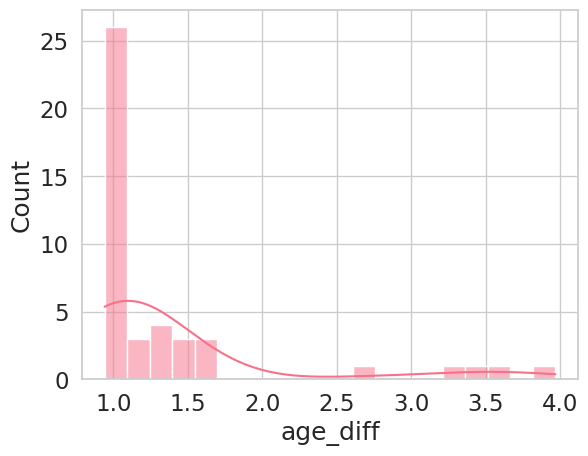

In [93]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    sns.histplot(MRI_age_diff["age_diff"], kde=True, bins=20)

### Neurocog ages

In [94]:
neurocog_df = demographic_df[demographic_df["assessment"]=="NEUROCOG"]
neurocog_df.head()

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
4,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROCOG,v1,60.19,NEUROCOG_v1
4,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,6,6.5,NaN,NEUROCOG,v1,79.23,NEUROCOG_v1
4,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,11,3.8,PD,NEUROCOG,v1,57.43,NEUROCOG_v1
4,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,12,10.2,PD,NEUROCOG,v1,69.28,NEUROCOG_v1
16,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,20+,6.8,PD,NEUROCOG,v1,50.16,NEUROCOG_v1


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


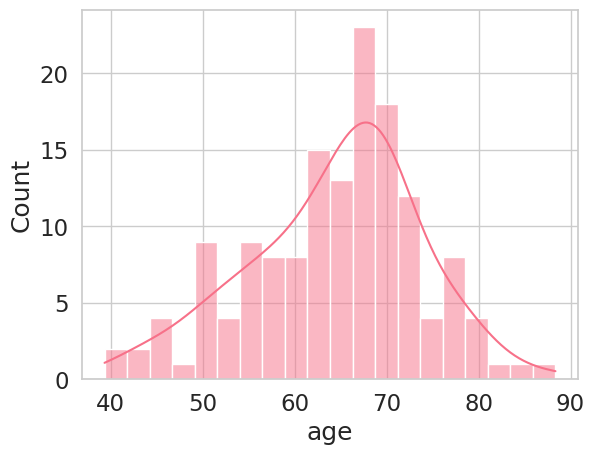

In [95]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    sns.histplot(neurocog_df["age"], kde=True, bins=20)

In [96]:
bagel_df["visit"].unique()

array(['MRI_v1', 'UPDRS_v1', 'MOCA_v1', 'NEUROPSY_v1', 'NEUROCOG_v1',
       'MRI_v2', 'UPDRS_v2', 'NEUROCOG_v2', 'missing_v0', 'MOCA_v2',
       'NEUROPSY_v2', 'MOCA_v3', 'UPDRS_v3'], dtype=object)

In [97]:
bagel_df.head()

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,...,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status,age_status,sex_status,years_education_at_screening_status,duration_disease_at_screening_status,bids_id
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MRI,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028
1,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,UPDRS,v1,60.19,...,True,True,True,True,False,True,True,True,True,sub-MNI0028
2,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MOCA,v1,60.19,...,False,False,False,False,True,True,True,True,True,sub-MNI0028
3,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROPSY,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028
4,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,NEUROCOG,v1,60.19,...,False,False,False,False,False,True,True,True,True,sub-MNI0028


In [98]:
bagel_df[bagel_df["participant_id"]=="MNI0342"]

,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,...,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status,age_status,sex_status,years_education_at_screening_status,duration_disease_at_screening_status,bids_id
161,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,UPDRS,v1,66.56,...,True,True,True,True,False,True,True,False,True,sub-MNI0342
162,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,MOCA,v1,66.56,...,False,False,False,False,True,True,True,False,True,sub-MNI0342
163,MNI0342,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,NaN,1.8,PSP,NEUROPSY,v1,66.57,...,False,False,False,False,False,True,True,False,True,sub-MNI0342


In [99]:
current_nipoppy_manifest_df[current_nipoppy_manifest_df["participant_id"]=="MNI0342"]

,participant_id,visit,session
231,MNI0342,MRI_v1,ses-01


In [100]:
legacy_recruit_df[legacy_recruit_df["participant_id"]=="MNI0342"]

,participant_id,session,scanner_acq_date,visit_id,suivi_MRI_date,dicom_date,legacy_sex,legacy_dob,legacy_group,legacy_date_MRI,legacy_age_MRI
